**Image retrieval**

In [0]:
# check tensorflow version and gpu
import tensorflow as tf

print(tf.__version__)
print(tf.test.gpu_device_name())

# memory footprint support libraries/code
!ln -sf /opt/bin/nvidia-smi /usr/bin/nvidia-smi
!pip install gputil
!pip install psutil
!pip install humanize
import psutil
import humanize
import os
import GPUtil as GPU
GPUs = GPU.getGPUs()
# XXX: only one GPU on Colab and isn’t guaranteed
gpu = GPUs[0]
process = psutil.Process(os.getpid())
print("Gen RAM Free: " + humanize.naturalsize( psutil.virtual_memory().available ), " | Proc size: " + humanize.naturalsize( process.memory_info().rss))
print("GPU RAM Free: {0:.0f}MB | Used: {1:.0f}MB | Util {2:3.0f}% | Total {3:.0f}MB".format(gpu.memoryFree, gpu.memoryUsed, gpu.memoryUtil*100, gpu.memoryTotal))

1.15.0
/device:GPU:0
Gen RAM Free: 14.6 GB  | Proc size: 13.0 GB
GPU RAM Free: 511MB | Used: 15769MB | Util  97% | Total 16280MB


In [0]:
# download the food-101 data
import os

if 'food-101' in os.listdir():
  print('food-101 already exists!')
elif 'food-101.tar.gz' in os.listdir():
  print('Extract food-101...')
  !tar xzvf food-101.tar.gz
  print('Extract food-101 done!')
else:
  print('Download food-101...')
  !wget http://data.vision.ee.ethz.ch/cvl/food-101.tar.gz
  print('Download food-101 done!')
  print('Extract food-101...')
  !tar xzvf food-101.tar.gz
  print('Extract food-101 done!')

In [0]:
# split the data into tranining set and test set
from shutil import copy
from collections import defaultdict

def split_data(filepath, src, dest):
  class_images = defaultdict(list)
  with open(filepath, 'r') as txt:
    paths = [read.strip() for read in txt.readlines()]
    for path in paths:
      food = path.split('/')
      class_images[food[0]].append(food[1] + '.jpg')

  for food in class_images.keys():
    if not os.path.exists(os.path.join(dest, food)):
      os.makedirs(os.path.join(dest, food))
    for i in class_images[food]:
      copy(os.path.join(src, food, i), os.path.join(dest, food, i))
  print("Extracting Done!")

print('Extract training set...')
split_data('food-101/meta/train.txt', 'food-101/images', 'food-101/train')
print('Extract test set...')
split_data('food-101/meta/test.txt', 'food-101/images', 'food-101/test')

Extract training set...
Extracting Done!
Extract test set...
Extracting Done!


In [0]:
# data description
print('The size of training set:')
!cat food-101/meta/train.txt | wc -l
print('The size of test set:')
!cat food-101/meta/test.txt | wc -l

The size of training set:
75750
The size of test set:
25250


In [0]:
# fine tune the pretrained InceptionV3 model on food-101 data
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
from tensorflow import keras
from tensorflow.keras import regularizers
from tensorflow.keras.applications.inception_v3 import InceptionV3
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D, GlobalAveragePooling2D, AveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, CSVLogger
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.regularizers import l2

K.clear_session()
n_classes = 101
img_width, img_height = 299, 299
train_data_dir = 'food-101/train'
validation_data_dir = 'food-101/test'
nb_train_samples = 75750
nb_validation_samples = 25250
batch_size = 25

train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

test_datagen = ImageDataGenerator(rescale=1. / 255)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_height, img_width),
    batch_size=batch_size,
    class_mode='categorical')


inception = InceptionV3(weights='imagenet', include_top=False)
x = inception.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dropout(0.2)(x)

predictions = Dense(101, kernel_regularizer=regularizers.l2(0.005), activation='softmax')(x)

model = Model(inputs=inception.input, outputs=predictions)
model.compile(optimizer=SGD(lr=0.001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])
checkpointer = ModelCheckpoint(filepath='best_model.hdf5', verbose=1, save_best_only=True)
csv_logger = CSVLogger('history.log')

history = model.fit_generator(train_generator,
                    steps_per_epoch = nb_train_samples // batch_size,
                    validation_data=validation_generator,
                    validation_steps=nb_validation_samples // batch_size,
                    epochs=10,
                    verbose=1,
                    callbacks=[csv_logger, checkpointer])

model.save('model_trained.hdf5')

# download the models to local
from google.colab import files

files.download('history.log')

In [0]:
# plot the accuracy and loss
import matplotlib.pyplot as plt

def plot_accuracy(history,title):
    plt.title(title)
    plt.plot(history.history['acc'])
    plt.plot(history.history['val_acc'])
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train_accuracy', 'validation_accuracy'], loc='best')
    plt.show()
    
def plot_loss(history,title):
    plt.title(title)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train_loss', 'validation_loss'], loc='best')
    plt.show()


plot_accuracy(history,'FOOD101-Inceptionv3')
plot_loss(history,'FOOD101-Inceptionv3')

In [0]:
# Loading the best saved model to make predictions
import tensorflow.keras.backend as K
from tensorflow.keras.models import load_model

K.clear_session()
best_model = load_model('best_model.hdf5', compile = False)

In [0]:
from tensorflow.keras.preprocessing import image
import matplotlib.pyplot as plt
import numpy as np
import os

def predict_class(model, images, show = True):
  food_list = [line.strip() for line in open('food-101/meta/classes.txt', 'r')]
  for img in images:
    img = image.load_img(img, target_size=(299, 299))
    img = image.img_to_array(img)                    
    img = np.expand_dims(img, axis=0)         
    img /= 255.                                      

    pred = model.predict(img)
    index = np.argmax(pred)
    pred_value = food_list[index]
    if show:
      plt.imshow(img[0])                           
      plt.axis('off')
      plt.title(pred_value)
      plt.show()

--2019-11-24 04:49:34--  http://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
Resolving veggiefoodrecipes.com (veggiefoodrecipes.com)... 62.75.168.50
Connecting to veggiefoodrecipes.com (veggiefoodrecipes.com)|62.75.168.50|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 75560 (74K) [image/jpeg]
Saving to: ‘samosa.jpg’

samosa.jpg          100%[===================>]  73.79K   249KB/s    in 0.3s    

2019-11-24 04:49:34 (249 KB/s) - ‘samosa.jpg’ saved [75560/75560]

--2019-11-24 04:49:35--  https://www.incredibleegg.org/wp-content/uploads/basic-french-omelet-930x550.jpg
Resolving www.incredibleegg.org (www.incredibleegg.org)... 35.224.134.160
Connecting to www.incredibleegg.org (www.incredibleegg.org)|35.224.134.160|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 109569 (107K) [image/jpeg]
Saving to: ‘omelette.jpg’

omelette.jpg        100%[===================>] 107.00K  --.-KB/s    in 0.09s   

2019-11-24 

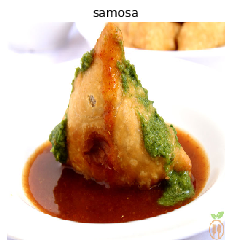

(1, 101)


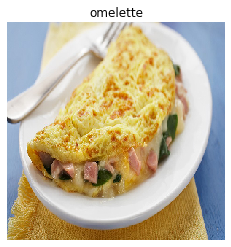

In [15]:
# Downloading images from internet using the URLs
!wget -O samosa.jpg http://veggiefoodrecipes.com/wp-content/uploads/2016/05/lentil-samosa-recipe-01.jpg
!wget -O omelette.jpg https://www.incredibleegg.org/wp-content/uploads/basic-french-omelet-930x550.jpg

images = []
images.append('samosa.jpg')
images.append('omelette.jpg')
predict_class(best_model, images, True)